# Laboratorio 2, Regresión

El objetivo de este notebook es entrenar un modelo de regresión lineal que permita predecir o estimar una variable objetivo continua a partir de una serie de variables observadas. Se busca estimar el precio de un vehículo usado. Se aborda el proceso general de entrenamiento de modelos de regresión, su validación en términos de las métricas de error más comunes y de la comprobación de supuestos, así como la interpretación de dichos modelos.

Este notebook se encuentra dividido en las siguientes secciones:

1. Carga de los datos
2. Entendimiento y limpieza de datos
3. Particionamiento del conjunto de datos en entrenamiento y prueba
4. Entrenamiento de un primer modelo
5. Entrenamiento de un segundo modelo aplicando normalización
6. Validación de los supuestos de la regresión
7. Persistencia del modelo y estimación para el nuevo conjunto de datos

Para la carga y manipulación de datos se utiliza la libreria **Pandas** (https://pandas.pydata.org/) y para la visualización **Matplotlib** (https://matplotlib.org/) y **Seaborn** (https://seaborn.pydata.org/). El algoritmo de regresión logística y funcionalidades complementarias se encuentran implementados en la libreria **Scikit-Learn** (https://scikit-learn.org/).

## Los datos

Se trabaja con un conjunto de datos que contiene linformación sobre vehículos usados en MotorAlpes. Contiene alrededor de 8000 vehículos usados junto a sus precios que se recomiendan apropiados.

In [25]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats

In [26]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

## 1. Carga de los datos

In [27]:
df_cars = pd.read_csv('./data/MotorAlpes_data.csv', sep=',', encoding = 'utf-8', index_col=0)

In [28]:
df_cars.shape

(7115, 11)

In [29]:
df_cars.sample(5)

,year,km_driven,owner,seller_type,seats,fuel,transmission,mileage,engine,max_power,selling_price
4295,2018.0,10500.0,First Owner,Individual,6.0,Petrol,Manual,18.15,1198.0,82.00,6663.44
831,2007.0,100000.0,Second Owner,Individual,5.0,Petrol,Manual,17.80,1086.0,63.00,1150.96
995,2013.0,40000.0,First Owner,Individual,5.0,Petrol,Manual,20.51,998.0,67.04,4240.37
4447,2013.0,90000.0,First Owner,Individual,5.0,Diesel,Manual,22.90,1248.0,74.00,4967.28
3389,2012.0,120000.0,First Owner,Individual,5.0,Diesel,Manual,21.12,1248.0,88.80,3477.10


In [30]:
df_cars_test = pd.read_csv('./data/MotorAlpes_test.csv', sep=',', encoding = 'utf-8', index_col=0)

In [31]:
df_cars_test.shape

(791, 10)

In [32]:
df_cars_test.sample(5)

,year,km_driven,owner,seller_type,seats,fuel,transmission,mileage,engine,max_power
819,NaN,70000.0,NaN,Individual,5.0,Diesel,Manual,25.80,1498.0,98.6
5082,2004.0,100000.0,Fourth & Above Owner,Individual,7.0,Diesel,Manual,10.50,2179.0,120.0
7531,2007.0,120000.0,Third Owner,Individual,5.0,Diesel,Manual,17.88,1396.0,52.8
4873,2018.0,35000.0,First Owner,Individual,5.0,Diesel,Manual,24.30,1248.0,88.5
2065,2013.0,140000.0,Second Owner,Individual,5.0,Diesel,Automatic,18.88,1995.0,184.0


## 2. Descripción de los datos

In [33]:
df_cars.dtypes

year             float64
km_driven        float64
owner             object
seller_type       object
seats            float64
fuel              object
transmission      object
mileage          float64
engine           float64
max_power        float64
selling_price    float64
dtype: object

#### 2.1 Datos númericos

In [34]:
df_cars.describe()

,year,km_driven,seats,mileage,engine,max_power,selling_price
count,6876.000000,6.917000e+03,7115.000000,6917.000000,6835.000000,6847.000000,6714.000000
mean,2013.980948,6.911118e+04,5.411103,19.523473,1835.489539,141.981595,11261.208041
std,3.852565,5.796521e+04,0.953555,4.241574,2363.919253,274.956684,40765.694516
min,1994.000000,1.000000e+00,2.000000,0.000000,4.000000,1.070000,1.910000
25%,2012.000000,3.400000e+04,5.000000,16.800000,1197.000000,68.050000,3210.560000
50%,2015.000000,6.000000e+04,5.000000,19.330000,1248.000000,83.100000,5451.900000
75%,2017.000000,9.400000e+04,5.000000,22.320000,1597.000000,104.680000,8480.740000
max,2020.000000,2.360457e+06,14.000000,46.816000,19972.000000,1995.640000,598983.440000


In [35]:
# Eliminar posibles outliers de acuerdo al diccionario de datos proporcionado
df_cars = df_cars[(df_cars['year'] >= 1994) & (df_cars['year'] <= 2020) &
                                 (df_cars['km_driven'] >= 1) & (df_cars['km_driven'] <= 2360457) &
                                 (df_cars['seats'] >= 2) & (df_cars['seats'] <= 14) &
                                 (df_cars['mileage'] >= 0) & (df_cars['mileage'] <= 46.816) &
                                 (df_cars['engine'] >= 624) & (df_cars['engine'] <= 3604) &
                                 (df_cars['max_power'] >= 32.8) & (df_cars['max_power'] <= 400) &
                                 (df_cars['selling_price'] >= 363.45) & (df_cars['selling_price'] <= 121153.38)]

In [36]:
df_cars.shape

(5458, 11)

#### 2.2 Datos categóricos

In [37]:
# Es posible obligar a tener en cuenta valores nulos así como retornar la frecuencia relativa en lugar de la absoluta
df_cars['owner'].value_counts(dropna = False, normalize = True)

First Owner             0.656284
Second Owner            0.257054
Third Owner             0.065409
Fourth & Above Owner    0.020887
Test Drive Car          0.000366
Name: owner, dtype: float64

In [38]:
# Es posible obligar a tener en cuenta valores nulos así como retornar la frecuencia relativa en lugar de la absoluta
df_cars['seller_type'].value_counts(dropna = False, normalize = True)

Individual          0.832906
Dealer              0.137779
Trustmark Dealer    0.029315
Name: seller_type, dtype: float64

In [39]:
# Es posible obligar a tener en cuenta valores nulos así como retornar la frecuencia relativa en lugar de la absoluta
df_cars['fuel'].value_counts(dropna = False, normalize = True)

Diesel    0.539392
Petrol    0.449249
CNG       0.006413
LPG       0.004947
Name: fuel, dtype: float64

In [40]:
# Es posible obligar a tener en cuenta valores nulos así como retornar la frecuencia relativa en lugar de la absoluta
df_cars['transmission'].value_counts(dropna = False, normalize = True)

Manual       0.869916
Automatic    0.130084
Name: transmission, dtype: float64

# 3. Limpieza de datos

#### 3.1 Completitud

In [41]:
# Ver el porcentaje de atributos vacios
df_porcentajes = (100*df_cars.isna().sum()/len(df_cars)).to_frame()
df_porcentajes.sort_values(0, ascending = False)

,0
year,0.0
km_driven,0.0
owner,0.0
seller_type,0.0
seats,0.0
fuel,0.0
transmission,0.0
mileage,0.0
engine,0.0
max_power,0.0


#### 3.2 Duplicidad

In [81]:
# Revisamos cada columna para ver cuantos valores repetidos tiene
# el comando duplicated() no dice que filas tinen valores duplicados.
non_number_cols = df_cars.dtypes[(df_cars.dtypes != np.int64) & (df_cars.dtypes != np.float64)].index 
for col in non_number_cols:
    num_duplicated = df_cars.duplicated(subset = col).sum()
    print(f"{col}: {num_duplicated}")

# Se exportan los datos para herramientas de visualización.
df_cars.to_csv('./data/df_cars.csv', index=False)

owner_First Owner: 5456
owner_Fourth & Above Owner: 5456
owner_Test Drive Car: 5456
owner_Third Owner: 5456
seller_type_Dealer: 5456
seller_type_Trustmark Dealer: 5456
fuel_CNG: 5456
fuel_Diesel: 5456
fuel_LPG: 5456
transmission_Automatic: 5456


# 4. Convertir variables

In [43]:
#Calcular los valores atípicos utilizando la regla de los cuartiles
q1 = df_cars.quantile(0.25)
q3 = df_cars.quantile(0.75)
IQR = q3 - q1

#Eliminar los valores atípicos utilizando la regla de los cuartiles
df_cars_out = df_cars[~((df_cars < (q1 - 1.5 * IQR)) | (df_cars > (q3 + 1.5 * IQR))).any(axis=1)]

/var/folders/x7/86msfzy10gn62hrc2kbqnsyw0000gq/T/ipykernel_98896/412866150.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q1 = df_cars.quantile(0.25)
/var/folders/x7/86msfzy10gn62hrc2kbqnsyw0000gq/T/ipykernel_98896/412866150.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q3 = df_cars.quantile(0.75)
/var/folders/x7/86msfzy10gn62hrc2kbqnsyw0000gq/T/ipykernel_98896/412866150.py:7: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_cars_out = df_cars[~((df_cars < (

In [44]:
# Convertir variables categoricas a numericas
df_cars = pd.get_dummies(df_cars, columns=['owner', 'seller_type', 'fuel', 'transmission'])


### 5.1 Búsqueda de relaciones entre variables

Si se logra visualizar o cuantificar una alta correlación entre las variables a usar para el entrenamiento del modelo con respecto a la variable objetivo, se podrán soportar las decisiones del experto con base en la evidencia.

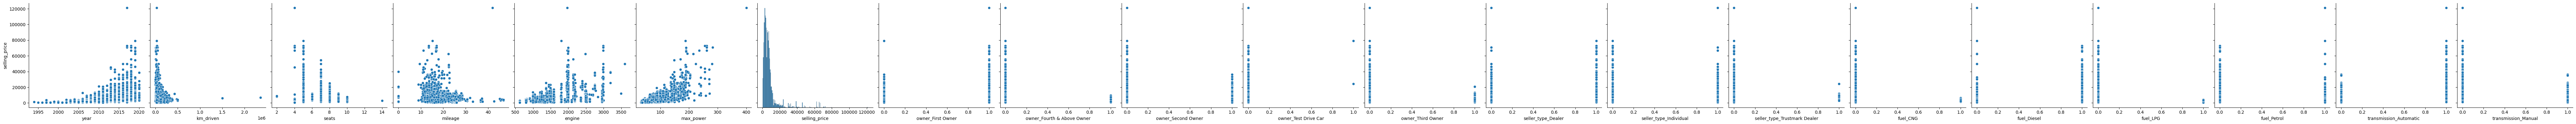

In [45]:
sns.pairplot(df_cars, height = 4, y_vars = 'selling_price', x_vars = df_cars.columns, kind = 'scatter')

### 5.2. Búsqueda de relaciones entre los atributos

**Importante:** La regresión lineal asume que las variables de entrada son independientes entre ellas (a nivel práctico que no se encuentran altamente correlacionados).
Se revisará ese supuesto con la siguiente gráfica.

<Axes: >

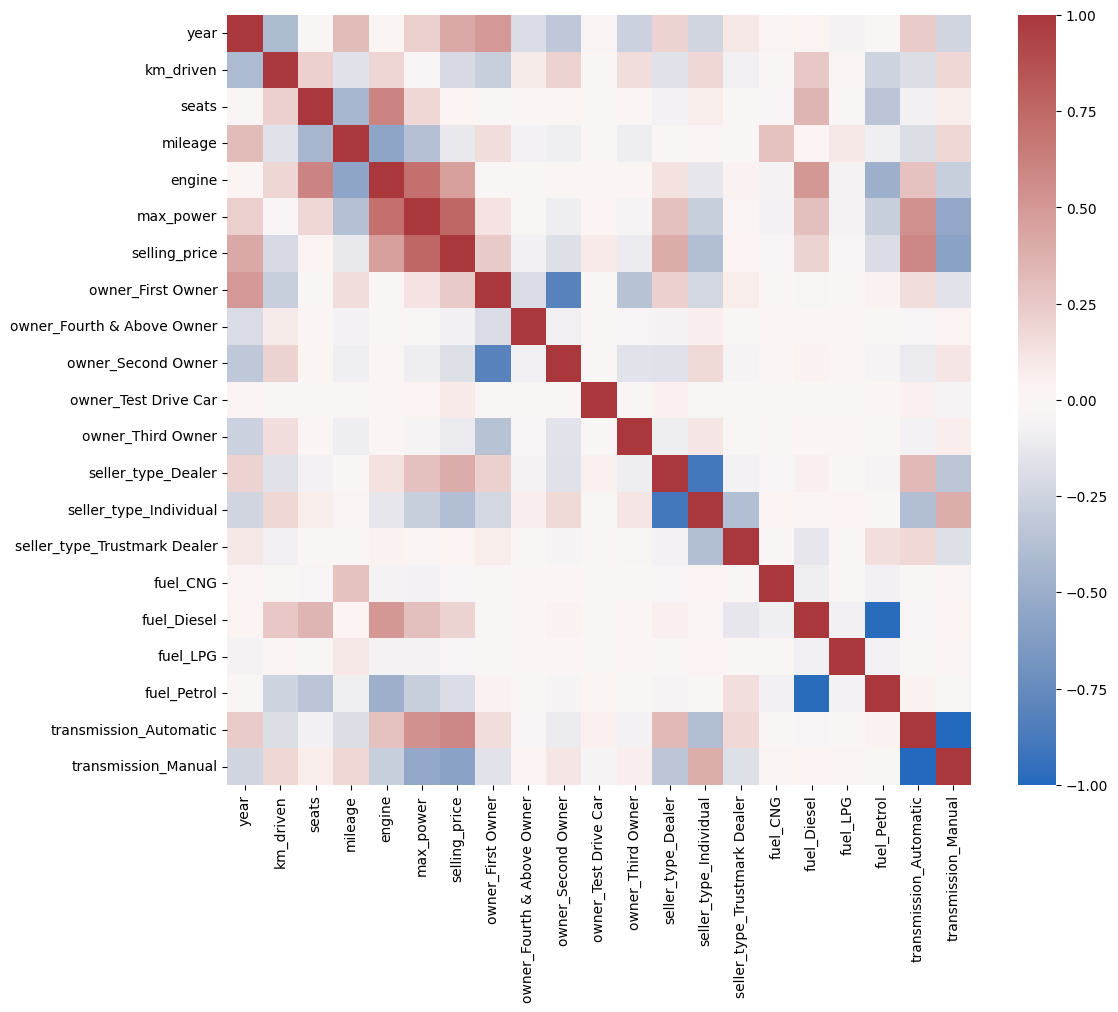

In [46]:
features = df_cars.columns
plt.figure(figsize = (12, 10))
sns.heatmap(df_cars[features].corr(), cmap = 'vlag', vmin = -1, vmax = 1)

Un buen punto de corte (empírico) para decidir si descartar una variable debido a su alta correlación con otra es ~$|0.8|$.Este valor depende del contexto.

In [47]:
# Filtar solo las columnas con una correlacion mayor al valor absoluto de 0.8
corr_matrix = df_cars[features].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
to_drop

['owner_Second Owner',
 'seller_type_Individual',
 'fuel_Petrol',
 'transmission_Manual']

In [48]:
# Eliminar columnas con alta correlación
df_cars.drop(columns = ['owner_Second Owner', 'transmission_Manual', 'fuel_Petrol', 'seller_type_Individual'], inplace = True)

<Axes: >

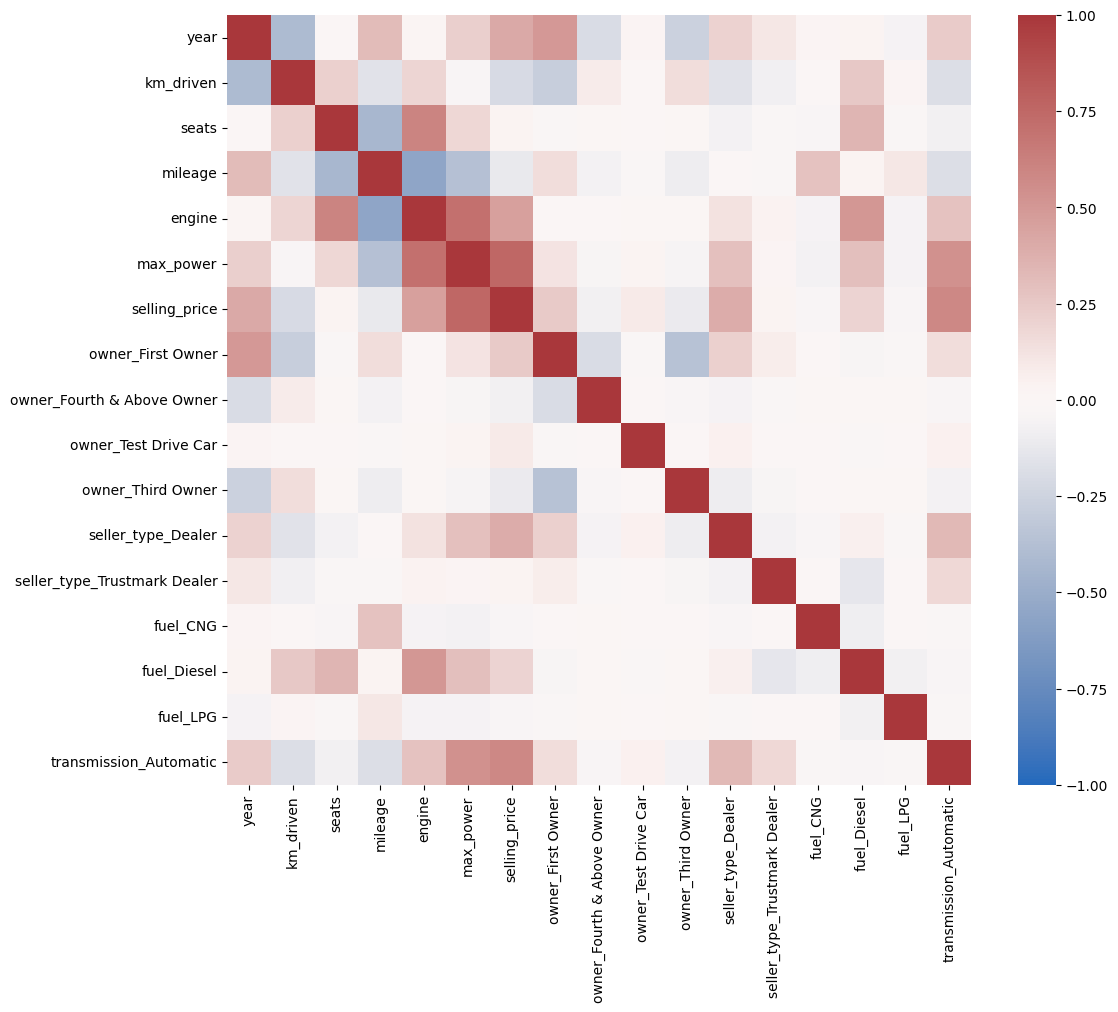

In [49]:
features = df_cars.columns
plt.figure(figsize = (12, 10))
sns.heatmap(df_cars[features].corr(), cmap = 'vlag', vmin = -1, vmax = 1)

## 6.1 Entrenamiento de modelos

Se desea construir un modelo que se ajuste bien a los datos de entrenamiento, pero que además se comporte de forma similar con datos desconocidos.

In [50]:
df = df_cars.copy()
df = df.reset_index(drop = True)
X_train, X_test, y_train, y_test = train_test_split(df.drop(['selling_price'], axis = 1), df['selling_price'], test_size = 0.3, random_state = 1)

In [51]:
X_train.shape, y_train.shape

((3820, 16), (3820,))

In [52]:
X_test.shape, y_test.shape

((1638, 16), (1638,))

In [53]:
regression = LinearRegression()

In [54]:
regression.fit(X_train, y_train)

LinearRegression()

In [55]:
# Ver score de entrenamiento y test
print('Train:', regression.score(X_train, y_train))
print('Test:', regression.score(X_test, y_test))

Train: 0.6815985113832421
Test: 0.6753035571188613


Eliminación de valores atípicos con cuartiles

In [56]:
df_cars_out = df_cars.copy()
q1 = df_cars_out.quantile(0.25)
q3 = df_cars_out.quantile(0.75)
IQR = q3 - q1
# Eliminar los valores atípicos utilizando unicamente en 'year', 'km_driven', 'seats', 'mileage', 'engine', 'max_power', 'selling_price'
df_cars_out = df_cars_out[~((df_cars_out[['year', 'km_driven', 'mileage', 'engine', 'max_power', 'selling_price']] < (q1 - 1.5 * IQR)) | (df_cars_out[['year', 'km_driven', 'mileage', 'engine', 'max_power', 'selling_price']] > (q3 + 1.5 * IQR))).any(axis=1)]
df_cars_out = df_cars_out.reset_index(drop = True)
X_train, X_test, y_train, y_test = train_test_split(df_cars_out.drop(['selling_price'], axis = 1), df_cars_out['selling_price'], test_size = 0.3, random_state = 1)

/var/folders/x7/86msfzy10gn62hrc2kbqnsyw0000gq/T/ipykernel_98896/238737873.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_cars_out = df_cars_out[~((df_cars_out[['year', 'km_driven', 'mileage', 'engine', 'max_power', 'selling_price']] < (q1 - 1.5 * IQR)) | (df_cars_out[['year', 'km_driven', 'mileage', 'engine', 'max_power', 'selling_price']] > (q3 + 1.5 * IQR))).any(axis=1)]
/var/folders/x7/86msfzy10gn62hrc2kbqnsyw0000gq/T/ipykernel_98896/238737873.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_cars_out = df_cars_out[~((df_cars_out[['year', 'km_driven', 'mileage', 'engine', 'max_power', 'selling_price']] < (q1 - 1.5 * IQR)) | (df_c

In [57]:
X_train.shape, y_train.shape

((2930, 16), (2930,))

In [58]:
X_test.shape, y_test.shape

((1257, 16), (1257,))

In [59]:
regression = LinearRegression()

In [60]:
regression.fit(X_train, y_train)

LinearRegression()

In [61]:
# Ver score de entrenamiento y test
print('Train:', regression.score(X_train, y_train))
print('Test:', regression.score(X_test, y_test))

Train: 0.7537636056125913
Test: 0.746048165847677


Se puede observar que el mejor resultado se obtiene al eliminar los outliers.

### 6.2 Utilizar únicamente variables donde se pueda observar alguna relación con la variable objetivo

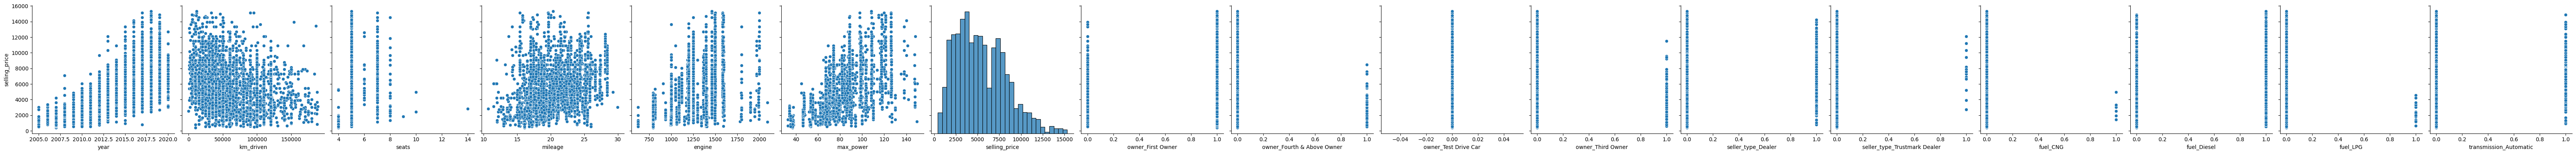

In [62]:
sns.pairplot(df_cars_out, height = 4, y_vars = 'selling_price', x_vars = df_cars_out.columns, kind = 'scatter')

In [63]:
df = df_cars_out.copy()
df = df.reset_index(drop = True)
X_train, X_test, y_train, y_test = train_test_split(df[['year', 'km_driven', 'mileage', 'engine', 'max_power']], df['selling_price'], test_size = 0.3, random_state = 1)

In [64]:
regression = LinearRegression()
regression.fit(X_train, y_train)

LinearRegression()

In [65]:
# Ver score de entrenamiento y test
print('Train:', regression.score(X_train, y_train))
print('Test:', regression.score(X_test, y_test))

Train: 0.7257661352472949
Test: 0.7193060753361291


El score empeora, por lo que alguna variable categórica debe ser importante para la predicción.

### 7.1. Interpretación de los coeficientes y del intercepto

Los coeficientes de la regresión brindan una intuición del impacto o la fuerza de una característica en la predicción/estimación de la variable objetivo.

In [66]:
df = df_cars_out.copy()
df = df.reset_index(drop = True)
X_train, X_test, y_train, y_test = train_test_split(df.drop(['selling_price'], axis = 1), df['selling_price'], test_size = 0.3, random_state = 1)

In [67]:
regression = LinearRegression()

In [68]:
regression.fit(X_train, y_train)

LinearRegression()

In [69]:
# Ver score de entrenamiento y test
print('Train:', regression.score(X_train, y_train))
print('Test:', regression.score(X_test, y_test))

Train: 0.7537636056125913
Test: 0.746048165847677


In [70]:
features = X_train.columns
pd.DataFrame({'columns': features, 'coef': regression.coef_})

,columns,coef
0,year,4.374983e+02
1,km_driven,-8.320565e-03
2,seats,2.010244e+02
3,mileage,-9.494508e+00
4,engine,-9.737537e-01
5,max_power,7.035382e+01
6,owner_First Owner,4.167373e+02
7,owner_Fourth & Above Owner,1.238599e+02
8,owner_Test Drive Car,3.410605e-13
9,owner_Third Owner,7.735970e+01


Note que las características ("features") se encuentran en diferentes escalas, rangos o grados de magnitud, razón por la cuál la interpretación de los coeficientes puede no ser la correcta. Si bien este no es el escenario, otro posible problema del uso de características en diferentes escalas es que el modelo se puede sesgar hacia las que tienen mayores escalas, basando su estimación mayoritariamente en estas y tendiendo a descartar las otras.

In [71]:
regression.intercept_

-881616.8590055172

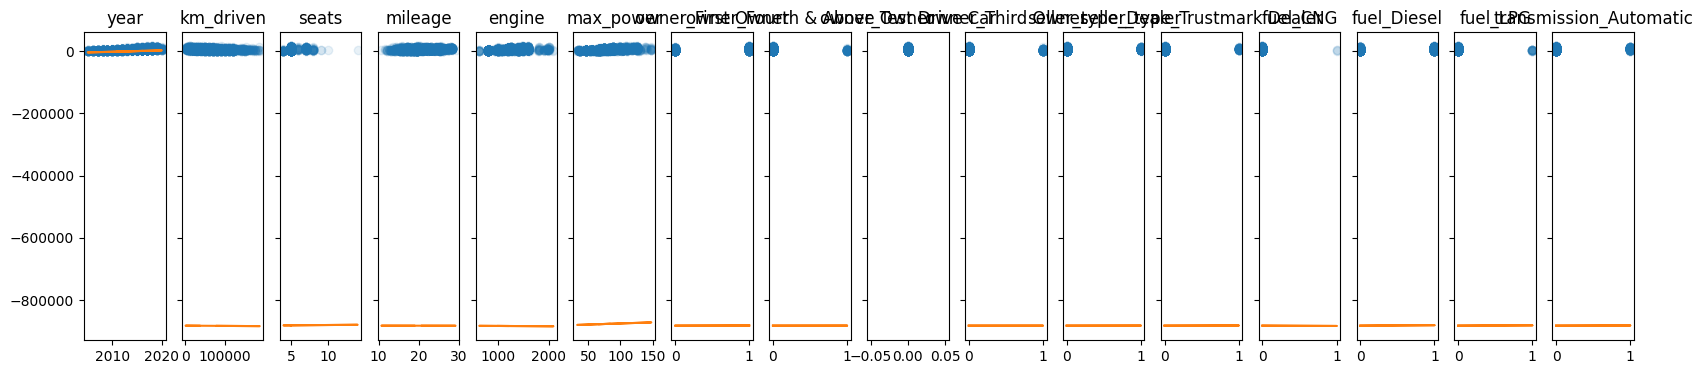

In [72]:
f, axs = plt.subplots(1, len(features), sharey = True, figsize = (20, 4))

for i in range(len(features)):
    col = features[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, 'o', alpha = 0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)

### 4.2. Validación del modelo

**Mean Absolute Error (MAE)**

$$ MAE = {1 \over n}{\sum_{i=1}^n {|y_{i} - y_{i}'|} } $$

In [73]:
print('Train:', mean_absolute_error(y_train, regression.predict(X_train)))
print('Test:', mean_absolute_error(y_test, regression.predict(X_test)))

Train: 1109.2449183905005
Test: 1128.2288801267023


**Root Mean Squeared Error (RMSE)**

$$ RMSE = {1 \over n}{\sum_{i=1}^n {(y_{i} - y_{i}')^2} } $$

**Revisa la métrica MAPE**, puede ser muy interesante para explicar mejor a un experto el resultado.

In [74]:
print('Train:', np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print('Test:', np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

Train: 1434.3048169039087
Test: 1464.5485694859844


**Análisis del error**

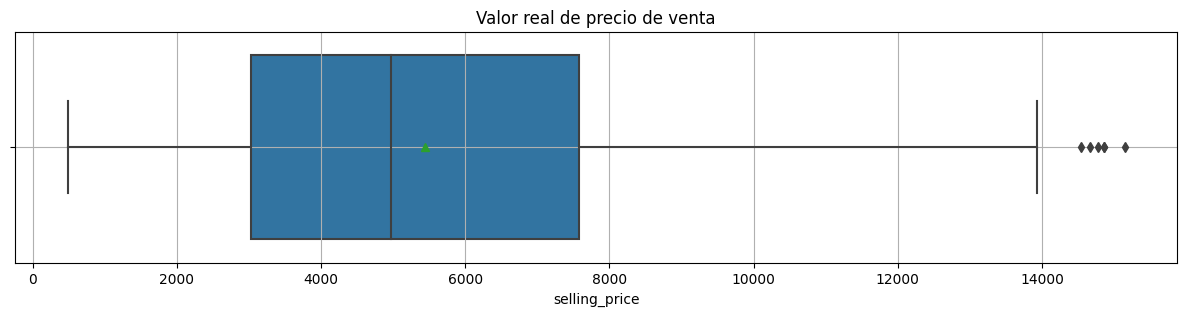

In [75]:
plt.figure(figsize = (15, 3))
sns.boxplot(x = y_test, showmeans = True, orient = 'h')
plt.title('Valor real de precio de venta')
plt.grid()
plt.show()

In [76]:
y_test.describe()

count     1257.000000
mean      5438.155044
std       2907.374126
min        484.610000
25%       3028.830000
50%       4967.280000
75%       7572.090000
max      15144.170000
Name: selling_price, dtype: float64

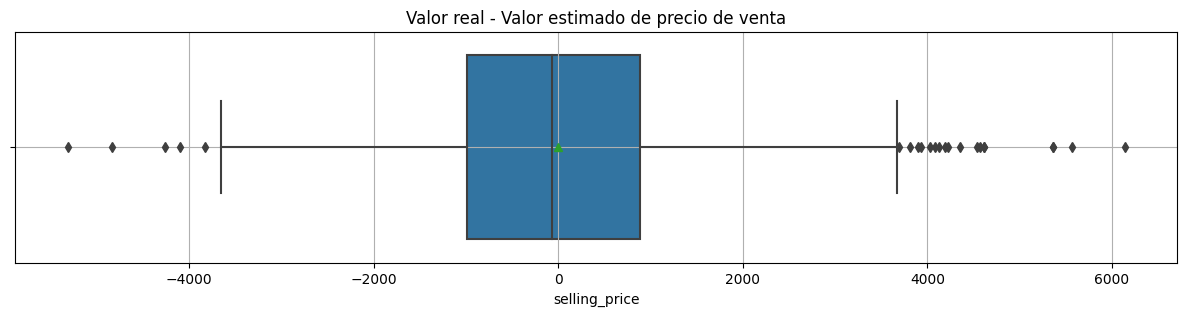

In [77]:
plt.figure(figsize = (15, 3))
sns.boxplot(x = (y_test - regression.predict(X_test)), showmeans = True, orient = 'h')
plt.title('Valor real - Valor estimado de precio de venta')
plt.grid()
plt.show()

In [78]:
abs(y_test - regression.predict(X_test)).describe()

count    1257.000000
mean     1128.228880
std       934.182196
min         1.206169
25%       411.951443
50%       933.146081
75%      1639.313177
max      6135.594767
Name: selling_price, dtype: float64

Se podría decir que los resultados de este primer modelo son aceptables dado que:
1) Las métricas de error para el dataset de entrenamiento y prueba son muy similares. No se evidencian problemas de sobreajuste (overfitting).
2) Para el conjunto de prueba los valores de la variable objetivo están centrados en $4967 \pm 0.075$, mientras que el 50% de los errores de estimación del modelo se encuentran entre $\pm 933$.

## 7. Persistencia del modelo

In [79]:
filename = 'model.joblib'
dump(regression, filename)

['model.joblib']